In [1]:
using Pkg

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "TissueRigidity"
 
projectname()

"TissueRigidity"

In [2]:
using DifferentialEquations
using StatsBase
using CairoMakie
using XLSX
using DataFrames
using Optimization, OptimizationPolyalgorithms, SciMLSensitivity,OptimizationOptimJL,OptimizationBBO,OptimizationNOMAD

┌ Warning: Error requiring `Enzyme` from `LinearSolve`
│   exception = (LoadError("/Users/boothh/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveEnzymeExt.jl", 1, ArgumentError("Package LinearSolve does not have Enzyme in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added Enzyme as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011c9f77ec, Ptr{Nothing} @0x000000011c9f7a36, Ptr{Nothing} @0x00000001096b66bd, Ptr{Nothing} @0x00000001096eda6d, Ptr{Nothing} @0x00000001096ec84f, Ptr{Nothing} @0x00000001096ed039, Ptr{Nothing} @0x00000001096eccad, Ptr{Nothing} @0x00000001096edef5, Ptr{Nothing} @0x0000000125f75c41, Ptr{Nothing} @0x0000000109

In [23]:
include(srcdirx("Plotting&Utility.jl"))
include(srcdirx("FittingFunctions.jl"))
# include(srcdirx("old/FittingFunctions_old_cmax.jl"))

include(srcdirx("NodalLefty_E.jl"))

exp_name = "NodalLefty_RelayDiffusion_Optimal_v2"

include(srcdirx("ExperimentSetups/" * exp_name * ".jl"))

include(scriptsdirx("LoadData.jl"));

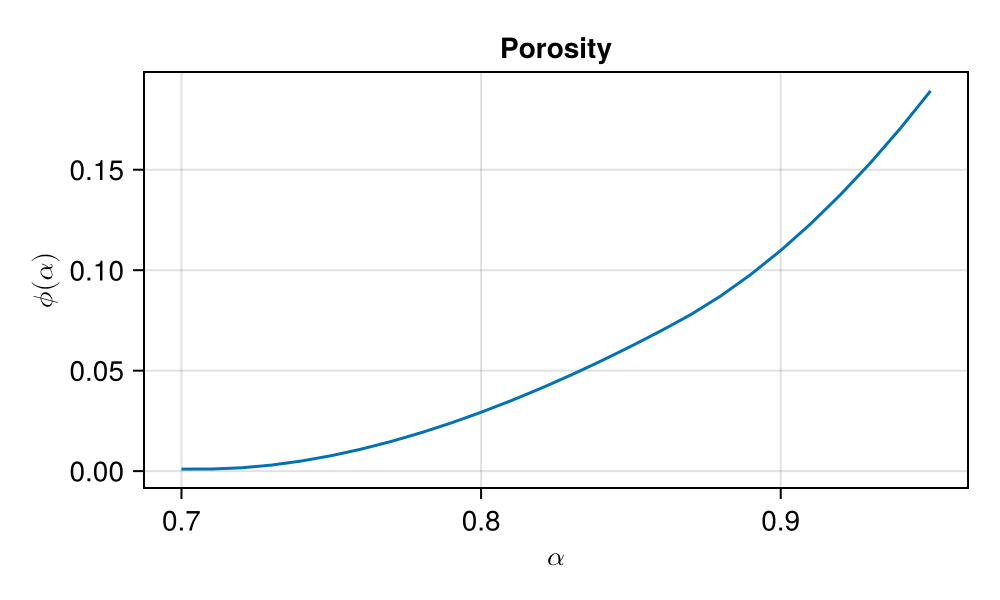

In [4]:
α_range = 0.7:0.01:0.95

fig = Figure(size = (500,300))
ax1 = Axis(fig[1,1],title = "Porosity",ylabel = L"\phi(\alpha)",xlabel = L"\alpha")

lines!(ax1, α_range,[ϕ(α) for α in α_range])

fig

In [5]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]
# pv_orig = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_OptParmas.jld2")["OptimalParam"][3]

p_orig,p_cp_orig,p_lm_orig = get_params(pv_orig)

tspan = (0,Inf)

u0 = ones(Nc,4)

u0[:,1] .= 1e-10
u0[:,2] .= 1e-10
u0[:,3] .= 0.
u0[:,4] .= α0

prob = ODEProblem(nodal_lefty_spatial_diff!,u0,tspan,p_orig)

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

lb[3:end] = (1 - γ) .* lb[3:end]
ub[3:end] = (1 + γ) .* ub[3:end];

In [6]:
orig_metrics = get_summary_metrics(pv_orig,prob,data,alpha_data,0.2)

(wt_t0 = 470.2152619507807, cp_t0 = 626.9536826010409, wt_xMax = 31.103678929765888, cp_xMax = 46.15384615384615, lm_xMax = 300.0, wt_d0 = 0.1935483870967742, cp_d0 = 0.41304347826086957, lm_d0 = 1.0, xmax_peak_ratio = 1.3333333333333333, xmax_mse = (0.30098897156021387, 0.3054581002057827), xmax_mse_half = (0.30098897156021387, 0.2912572886669174), alpha_mse = 0.007627237652381885, cp_lprod_t0 = 388.31590701641056, wt_lprod_t0 = 310.65272561312844, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [24]:
orig_metrics = get_summary_metrics_cpset(pv_orig,prob,data,alpha_data,[0.2])

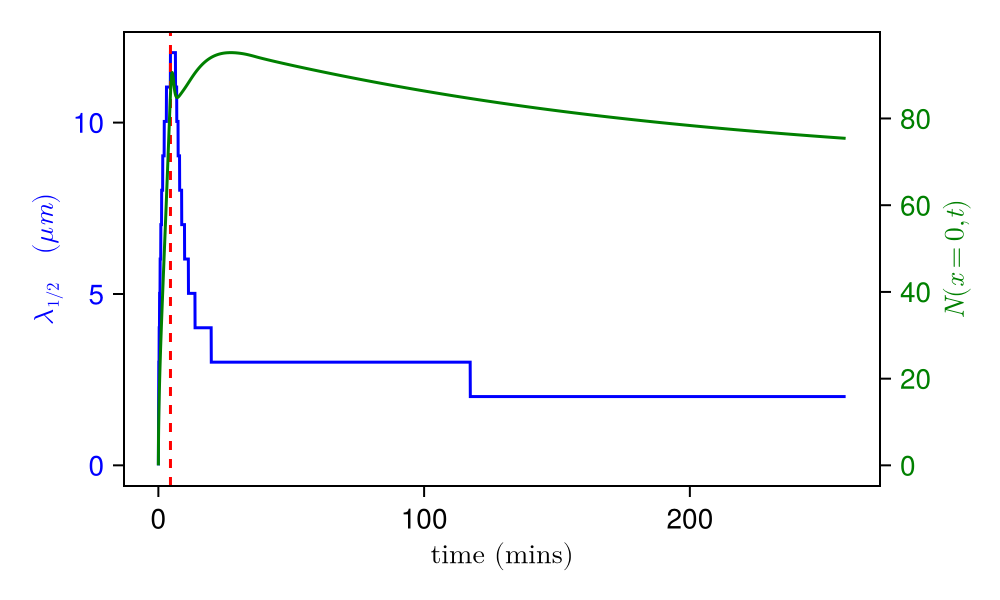

In [8]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_N)

sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

N_samp = 5000

λ_trange = LinRange(0.,sol.t[end],N_samp)

N0t = [sol(t)[1,1] for t in λ_trange]

λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

c_max = maximum(sol(λhalf_max_t)[:,1])

lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT.pdf"),fig)

fig

In [ ]:
fig = Figure(size = (1200,1200))

# fig = plot_summary!(fig,[DN0,DL0,kN0,kL0,2*kE,0.5*kNL,σN0,0.9*σL0,1.2*Na,NL,NE,LN,s0],prob)

# fig = plot_summary!(fig,[DN0,DL0,0.5*kN0,kL0,2*kE,0.5*kNL,σN0,0.7*σL0,1.5*Na,NL,0.3*NE,0.5*LN,s0],prob)

fig = plot_summary!(fig,[DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0],prob)

save(plotsdir(exp_name * "/OrigFits/Summary_orig.pdf"),fig)

fig


In [ ]:
# for i in 1:length(pv_orig)
#     print(i)
#     for pt in [0.8,1.2]
#         fig = Figure(size = (1200,1200))
#         p_try = copy(pv_orig)
#         p_try[i] = p_try[i]*pt
#         plot_summary!(fig,p_try,prob)
#         save(plotsdir(exp_name * "/Perturb/08/" * p_names_string[p_names[i]] * "_" * string(pt) * ".pdf"),fig)
#     end
# end

In [ ]:
# for i in 1:length(pv_orig)
#     print(i)
#     for pt in [0.5,1.5]
#         fig = Figure(size = (1200,1200))
#         p_try = copy(pv_orig)
#         p_try[i] = p_try[i]*pt
#         plot_summary!(fig,p_try,prob)
#         save(plotsdir(exp_name * "/Perturb/05/" * p_names_string[p_names[i]] * "_" * string(pt) * ".pdf"),fig)
#     end
# end

In [11]:
sim_data = load(datadirx() * "/sims/" * exp_name * "_CPSet_Sweep_RestrID_nosig.jld2")["Results"];
sim_data_p = load(datadirx() * "/sims/" * exp_name * "_CPSet_Sweep_RestrID_nosig.jld2")["Parameters"];
res_id = findall(x->length(x) == 3 ,sim_data)

sim_data = sim_data[res_id]
sim_data_p =sim_data_p[res_id];

In [12]:
sim_data_02 = map(x->x[3],sim_data);

In [13]:
# sim_data_02_c1_id = findall(x-> (x[:wt_xMax] < x[:cp_xMax]) & (x[:wt_lprod_t0 ] < x[:cp_lprod_t0]) & (x[:cp_d0] < 0.5) & (x[:inc_met] < 10.) ,sim_data_02); P1

sim_data_02_c1_id = findall(x-> (x[:wt_xMax] < x[:cp_xMax]) & (1.2*x[:wt_lprod_t0 ] < x[:cp_lprod_t0]) & (x[:wt_d0] < 0.2)  & (x[:cp_d0] < 0.7) & (x[:inc_met] == 0) ,sim_data_02); #P2 - 22

# sim_data_02_c1_id = findall(x-> (x[:wt_xMax] < x[:cp_xMax]) & (x[:wt_lprod_t0 ] < x[:cp_lprod_t0]) & (x[:inc_met] < 0.1) ,sim_data_02);

148-element Vector{Int64}:
   611
   736
  2052
  3619
  5765
  7792
  7809
  8187
  9616
  9892
     ⋮
 88845
 89705
 90179
 90916
 92424
 92484
 94121
 95256
 96892

In [14]:
id = argmin(map(x->x[:alpha_mse],sim_data_02[sim_data_02_c1_id]))

id = 1

# id = argmin(map(x->mean(x[:xmax_mse]),sim_data_02[sim_data_02_c1_id]))

1

In [15]:
sim_data_02[sim_data_02_c1_id][id]

(wt_t0 = 4554.169238324791, cp_t0 = 4372.002468791799, wt_xMax = 133.44481605351172, cp_xMax = 209.69899665551839, lm_xMax = 300.0, wt_d0 = 0.15037593984962405, cp_d0 = 0.20095693779904306, lm_d0 = 1.0, xmax_peak_ratio = 0.96, xmax_mse = (2.0287099810851625, 1.81583935132363), xmax_mse_half = (2.0287099810851625, 2.572778186400831), alpha_mse = 0.002678282554528704, cp_lprod_t0 = 2516.4178373926775, wt_lprod_t0 = 943.656689022254, inc_met = 0.0, λhalf = [0.0, 1.0033444816053512, 2.0066889632107023, 3.0100334448160537, 3.0100334448160537, 4.013377926421405, 4.013377926421405, 4.013377926421405, 5.016722408026756, 5.016722408026756  …  8.02675585284281, 8.02675585284281, 8.02675585284281, 8.02675585284281, 8.02675585284281, 8.02675585284281, 8.02675585284281, 8.02675585284281, 8.02675585284281, 8.02675585284281], λhalf_ro = [0.0, 1.0033444816053512, 2.0066889632107023, 3.0100334448160537, 3.0100334448160537, 4.013377926421405, 4.013377926421405, 4.013377926421405, 5.016722408026756, 5.01

In [16]:
p_vector = sim_data_p[sim_data_02_c1_id][id]

# p,p_cp,p_lm = get_params(p_vector)

# sol = solve(prob, p = p, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
# sol_cp = solve(prob, p = p_cp, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
# sol_lm = solve(prob, p = p_lm, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

# λ_trange = LinRange(0.,sol.t[end],N_samp)

# λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

# c_max_wt = maximum(sol(λhalf_max_t)[:,1])

13-element Vector{Float64}:
   2.145
  15.11
   0.0008921666563884846
   1.5400497350002505e-6
   0.02040892755215013
  33.76098759594136
   0.4108
   4.863427082328215
  78.1
 419.184197150277
 173.63319562605918
  67.72133004523768
   5.01

In [17]:
# c_level = 0.2*c_max_wt

# t_grid = LinRange(0,sol.t[end],t_grid_N)

# level_x_wt = get_level_x(sol,c_level,t_grid);
# level_x_cp = get_level_x(sol_cp,c_level,t_grid)

# wt_t0 = t_grid[argmax(level_x_wt)];
# cp_t0 = t_grid[argmax(level_x_cp)];

# t_plot = LinRange(0,exp_times_times_norm[end],t_plot_N)

# level_x_wt_rescaled = get_level_x(sol,c_level,t_plot .* wt_t0)  
# level_x_cp_rescaled = get_level_x(sol_cp,c_level,t_plot .* wt_t0)
# level_x_lm_rescaled  = get_level_x(sol_lm,c_level,t_plot .* wt_t0)

# wt_xMax = maximum(level_x_wt_rescaled)
# cp_xMax = maximum(level_x_cp_rescaled)
# lm_xMax = maximum(level_x_lm_rescaled)

# wt_d0 = level_x_wt_rescaled[end] ./ wt_xMax
# cp_d0 = level_x_cp_rescaled[end] ./ cp_xMax
# lm_d0 = level_x_lm_rescaled[end] ./ lm_xMax

In [ ]:
fig = Figure(size = (1200,1200))
ax = Axis(fig[1,1])
lines!(ax,[sol.u[1]*exp(sol.u[2]*x) for x in tissue])
scatter!(ax,dynN)

fig

In [18]:
orig_metrics = get_summary_metrics_cpset(p_vector,prob,data,alpha_data,[0.2])

1-element Vector{Any}:
 (wt_t0 = 4550.153422926303, cp_t0 = 4368.147286009251, wt_xMax = 133.44481605351172, cp_xMax = 209.69899665551839, lm_xMax = 300.0, wt_d0 = 0.15037593984962405, cp_d0 = 0.20095693779904306, lm_d0 = 1.0, xmax_peak_ratio = 0.9599999999999999, xmax_mse = (2.0208644083974643, 1.8202062803023336), xmax_mse_half = (2.0208644083974643, 2.579527076640646), alpha_mse = 0.002677788866233061, cp_lprod_t0 = 2514.1988883436634, wt_lprod_t0 = 942.8245831288737, inc_met = 151.19961905335475, λhalf_max_t = 1452.5902869733202, λhalf_max_t_ro = 1506.656922964883, IF_Δ = (0.08880029518064247, 0.028983433785543928), retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [ ]:
sim_tuple, sim_cp_tuple,_ = get_params(p_vector)

In [ ]:
fig = Figure(size = (1200,1200))

fig = plot_summary!(fig,[sim_tuple[:DN0],sim_tuple[:DL0],sim_tuple[:kN0],sim_tuple[:kL0],sim_tuple[:kE],sim_tuple[:kNL],sim_tuple[:σN0],sim_tuple[:σL0],sim_tuple[:Na],sim_tuple[:NL],sim_tuple[:NE],sim_tuple[:LN],sim_tuple[:s0]],prob)

fig

In [ ]:
save(plotsdir(exp_name * "/OptFits/Sweep_opt_2_alpha.pdf"),fig)

In [ ]:
sol = solve(prob, p = sim_tuple, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_cp = solve(prob, p = sim_cp_tuple, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

In [ ]:
orig_metrics = get_summary_metrics(p_vector,prob,data,alpha_data,0.2)

t_plot_int = LinRange(0,3*orig_metrics[:wt_t0],1000)

nodal_prod_cp,nodal_prod = get_integrated_nodal_prod_values(sol,sol_cp,t_plot_int)


In [ ]:
fig = Figure(size = (500,500))

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, } t^{'}", ylabel= L"\int_0^L ν(N(t,x)) dx" )

lines!(ax,LinRange(0,3,1000),nodal_prod_cp,linestyle = :dash,color = :grey, label = L"\text{Wnt11}")
lines!(ax,LinRange(0,3,1000),nodal_prod,color = :grey, label = L"\text{WT}")

axislegend(ax,position = :rt)

save(plotsdir(exp_name * "/OptFits/IntegratedNodal.pdf"),fig)

fig

In [ ]:
fig = Figure(size = (500,500))


ax = Axis(fig[1,2], xlabel = L"\text{t, mins}", ylabel= L"\int_0^L ν_L(N(t,x)) dx" )

lines!(ax,ncp,linestyle = :dash,color = :grey, label = L"\text{Wnt11}")
lines!(axνN_int,color = :grey, label = L"\text{WT}")

axislegend(ax,position = :rt)

In [ ]:
save(plotsdir(exp_name * "/OptFits/Summary_Sweep_P2.pdf"),fig)

In [ ]:
pv_orig = [DN0,DL0,kN0,kL0,2*kE,0.5*kNL,σN0,0.9*σL0,1.2*Na,NL,NE,LN,s0]

In [ ]:
for i in 1:length(p_base)
    print(i)
    for pt in [0.8,1.2]
        fig = Figure(size = (1200,1200))
        p_try = copy(p_base)
        p_try[i] = p_try[i]*pt
        plot_summary!(fig,p_try,prob)
        save(plotsdir(exp_name * "/PerturbOpt/" * p_names_string[p_names[i]] * "_" * string(pt) * ".pdf"),fig)
    end

end

In [ ]:
map(x->x[:cp_lprod_t0] - x[:wt_lprod_t0],result_dict[:Na])

In [ ]:
p_names_string[p_names[1]]